# 12. Regression and Correlation
This notebook contains all the solutions to the twelfth chapter of Principles of Statistics (1965) by MG Bulmer

---

Set local environment

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error          # Function that calculates MSE
from sklearn.linear_model import LinearRegression       # Model without statistical inference
from statsmodels.regression.linear_model import OLS     # Model with statistical inference

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Exercise 12.1
From the data in Table 22 on p. 210 calculate $\sum x_i$, $\sum y_i$, $\sum x_i^2$, $\sum y_i^2$ and $\sum x_i y_i$ and hence find the equation of the best-fitting straight line. [In evaluating sums like $\sum x_i$ it should be remembered that each dose level occurs five times] Reproduce Fig. 30 and plot this line on it.

In [2]:
df = pd.DataFrame({'half':[8,1,1,3,1],'one':[5,6,9,7,4], 'two':[13,7,12,10,11],
                   'four':[17,14,14,19,13], 'eight':[17,17,20,18,15]})
df

,half,one,two,four,eight
0,8,5,13,17,17
1,1,6,7,14,17
2,1,9,12,14,20
3,3,7,10,19,18
4,1,4,11,13,15


This question is super interesting because the author does not tell the reader which independent variable to use. At the beginning of the chapter, Bulmer states that when $y$ is plotted against $\log_2(x)$, there is an approximately linear relationship.

For educational purposes, I will solve the problem twice:
1. $E(Y|X) = \alpha + \beta X$
2. $E(Y|X) = \alpha + \beta \log{X}$

As we will see, the first model has a really poor fit because $X$ and $Y$ do not linearly related. The second model, $\log{X}$ and $Y$, will fit much better.

Prior to solving though, it is much more convenient to reshape the data from its current for (`df`) to arrays.

Recall that
- $a = \bar{y} - b\bar{x}$
- $b = \frac{\sum x_i y_i - n\bar{x}\bar{y}}{\sum x_i^2 - n\bar{x}}$

### 12.1.1 $Y$ on $X$ (bad fit)

In [3]:
# Dependent variable as array
y = df.values.reshape(1, -1)[0]

# Independent variable as array
X = np.tile([0.5, 1, 2, 4, 8], 5)

# Sum of x_i
print('Sum of x_i:', X.sum())

# Sum of y_i
print('Sum of y_i:', y.sum())

# Sum of x_i^2
print('Sum of x_i^2:', np.power(X, 2).sum())

# Sum of y_i^2
print('Sum of y_i^2:', np.power(y, 2).sum())

# Sum of x_i^2 * y_i^2
print('Sum of x_i^2 * y_i^2:', (np.power(X, 2) * np.power(y, 2)).sum())

Sum of x_i: 77.5
Sum of y_i: 262
Sum of x_i^2: 426.25
Sum of y_i^2: 3604
Sum of x_i^2 * y_i^2: 119662.0


a = 4.88 
b= 1.81


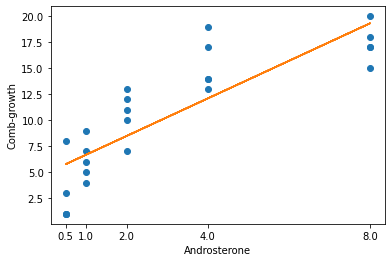

In [4]:
# Calculate coefficients by hand
n = len(X)
b = ((X * y).sum() - (X.sum() * y.mean())) / (np.power(X, 2).sum() - n * X.mean()**2)
a = y.mean() - b * X.mean()

# Print results
print('a =', round(a, 2), '\nb=', round(b, 2))

### Plot
# Data points
plt.scatter(X, y)
# Estimated line
plt.plot(X, a + b * X, color='C1', ls='--')
# Styling
plt.xlabel('Androsterone')
plt.ylabel('Comb-growth')
plt.xticks(ticks=[0.5,1,2,4,8])
plt.show()

### 12.1.2 $Y$ on $\log_2{X}$
This time around, we will not calculate $a$ and $b$ by hand. We will use `sklearn`.

Later though, when we have to make inferences about the estimates, we will use `statsmodels`.

First, we have to transform $X$.

a = 6.64 
b= 3.84


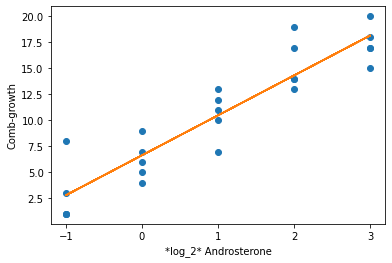

In [5]:
# log_2(X)
X = np.log2(X)

# Initialize linear model from sklearn
lm = LinearRegression()

# Fit model to data
lm.fit(X.reshape(-1, 1), y)

# Print results
print('a =', round(lm.intercept_, 2), '\nb=', round(lm.coef_[0], 2))

### Plot
# Data points
plt.scatter(X, y)
# Estimated line
plt.plot(X, lm.predict(X.reshape(-1, 1)), color='C1')
# Styling
plt.xlabel('*log_2* Androsterone')
plt.ylabel('Comb-growth')
plt.xticks(ticks=np.log2([0.5,1,2,4,8]))
plt.show()

In order to gain a sense of the benefit of transforming $X$ into $\log_2{X}$, we calculate the mean squared error of both models.

In [6]:
print('MSE of Y on X:\n   ',
      mean_squared_error(y, a + b * X))
print('MSE of Y on log_2(X):\n   ',
      mean_squared_error(y, lm.predict(X.reshape(-1, 1))))

MSE of Y on X:
    27.491669152503174
MSE of Y on log_2(X):
    4.838399999999999


As predicted by the author, the transformed variable results in a much better fit because the relationship is now approximately linear.

# Exercise 12.2
Find the residual sum of squares in the above example (a) directly by squaring the deviations of the observed and predicted points, (b) from the formula on p.213.

*Note:* I will use the second linear model since it has a much better fit to the data.

In [7]:
# MSE by a)
print('MSE by a)',
      np.power(y - lm.predict(X.reshape(-1, 1)), 2).sum())

# MSE by b)
print('MSE by b)',
      np.power(y - y.mean(), 2).sum() - lm.coef_[0]**2 * np.power(X - X.mean(), 2).sum())

MSE by a) 120.95999999999998
MSE by b) 120.96000000000026


# Exercise 12.3
Find 95% confidence intervals for $\alpha$ and $\beta$ in the above example.

*Solution*

$a$ and $b$ follow the *t* distribution with $n - 2$ degrees of freedom. In order to build confidence intervals, we would have to calculate the corresponding statistics under $H_0$ and compare against the critical values of a standard *t* distribution.

The statistics for $a$ and $b$ are:

$T_a = \frac{a - \alpha_0}{\sqrt{\frac{\sum e_i^2}{n - 2}(\frac{1}{n} + \frac{\bar{x}^2}
{\sum (x_i - \bar{x})^2})}}$

$T_b = \frac{b - \beta_0}{\sqrt{\frac{\frac{\sum e_i^2}{n - 2}}{\sum (x_i - \bar{x})^2}}}$

Calculating these statistics is tedious and there are statisticals packages that do this for us. We can run the regression of growth on dose using `statsmodels`:

In [8]:
# In order to fit an intercept, statsmodels requires a column full of ones
X = np.stack([np.ones(len(X)), X], axis=1)

# Initialize and fit model (Note that statsmodels `fit` does not replace the object like sklearn)
lm = OLS(endog=y, exog=X)
lm = lm.fit()

# Print summary table
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     140.2
Date:                Tue, 04 May 2021   Prob (F-statistic):           2.89e-11
Time:                        00:57:03   Log-Likelihood:                -55.181
No. Observations:                  25   AIC:                             114.4
Df Residuals:                      23   BIC:                             116.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6400      0.562     11.820      0.0

The confidence interval for $\alpha$ is $[5.478, 7.802]$

The confidence interval for $\beta$ is $[3.169, 4.511]$

# Exercise 12.4
Find the regressions of head breadth on head length and of head length for the data in Table 10 on p. 40 (see Exercises 4.6, 4.7 and 5.5). Find also the mean head breadth for fixed head lengths and vice versa and hence reconstruct Fig 23.

- Head breadth, $B$, is at the top of the table.
- Head length, $L$, is at the left hand side of the table.

In [9]:
df = pd.DataFrame({'13.25':[0,0,0,1,0,0,0,0,0,0,0],
                   '13.75':[0,0,5,8,6,5,10,1,2,0,0],
                   '14.25':[0,1,4,17,55,108,72,28,4,1,1],
                   '14.75':[0,0,4,15,119,264,360,174,31,4,0],
                   '15.25':[1,1,1,11,74,234,400,239,86,17,0],
                   '15.75':[0,0,0,2,14,75,156,160,100,17,1],
                   '16.25':[0,0,0,0,1,6,26,36,24,5,0],
                   '16.75':[0,0,0,0,0,1,2,7,2,0,1]},
                  index=np.arange(16.25, 21.5, .5).astype(str))
df

,13.25,13.75,14.25,14.75,15.25,15.75,16.25,16.75
16.25,0,0,0,0,1,0,0,0
16.75,0,0,1,0,1,0,0,0
17.25,0,5,4,4,1,0,0,0
17.75,1,8,17,15,11,2,0,0
18.25,0,6,55,119,74,14,1,0
18.75,0,5,108,264,234,75,6,1
19.25,0,10,72,360,400,156,26,2
19.75,0,1,28,174,239,160,36,7
20.25,0,2,4,31,86,100,24,2
20.75,0,0,1,4,17,17,5,0


The data is given in grouped frequency form. That is, for every category $(\text{breadth}, \text{length})$, we are given the number of observations in that group. Hence, operators such as $\sum x_i y_i$ cannot be computed in this form.

We must therefore convert the data into individual observations to form two vectors of size 3000 each:
- $b$: One observed head breadth per recorded criminal
- $l$: One observed head length per recorded criminal

In [10]:
# Empty arrays of head breadths and head lengths
b, l = np.array([]), np.array([])

# Repeat each observation according to its frequency
for nrow in range(df.shape[0]):
    for ncol in range(df.shape[1]):
        # Head breadth
        breadth = float(df.columns[ncol])
        # Head length
        length = float(df.index[nrow])
        # Frequency
        freq = df.iloc[nrow, ncol]
        # Append individual observations
        if freq > 0:
            b = np.concatenate([b, np.repeat(breadth, repeats=freq)])
            l = np.concatenate([l, np.repeat(length, repeats=freq)])

Run regressions:
1. $lm_1$: The regression of head breadth on head length
2. $lm_2$: The regression of head length on head breadth

In [11]:
# Head breadth on head length
lm1 = LinearRegression().fit(l.reshape(-1, 1), b)
print('Head breadth on length:\n    a =', lm1.intercept_, '\n    b =', lm1.coef_.item(), '\n')

# Head length on head breadth
lm2 = LinearRegression().fit(b.reshape(-1, 1), l)
print('Head length on breadth:\n    a =', lm2.intercept_, '\n    b =', lm2.coef_.item(), '\n')

Head breadth on length:
    a = 9.02892433251265 
    b = 0.3157979744101221 

Head length on breadth:
    a = 12.399420486239014 
    b = 0.4517559727411461 



Let's turn `df`, which is given as frequencies per group, into a `pandas.DataFrame` object with individual observations per row. That way, we can get the average of head breadth grouped by head length and vice versa.

In [12]:
df = pd.DataFrame(np.stack([b, l], axis=1), columns=['breadth','length'])
df.head()

,breadth,length
0,15.25,16.25
1,14.25,16.75
2,15.25,16.75
3,13.75,17.25
4,13.75,17.25


In [13]:
# Average head breadth for fixed head lengths
cond_b = df.groupby('length')['breadth'].mean()

# Average head length for fixed head breadths
cond_l = df.groupby('breadth')['length'].mean()

Plot

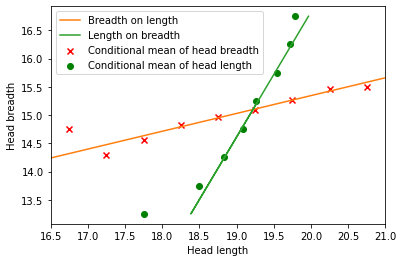

In [14]:
# Head breadth on head length
plt.plot(l, lm1.intercept_ + lm1.coef_.item() * l, color='C1',
         label='Breadth on length')
# Head length on head breadth
plt.plot(lm2.intercept_ + lm2.coef_.item() * b, b, color='C2',
         label='Length on breadth')
# Conditional head breadth
plt.scatter(cond_b.index, cond_b.values, color='red', marker='x',
            label='Conditional mean of head breadth')
# Conditional head length
plt.scatter(cond_l.values, cond_l.index, color='green', marker='o',
            label='Conditional mean of head length')
# Styling
plt.xlim(16.5, 21)
plt.xlabel('Head length')
plt.ylabel('Head breadth')
plt.legend()
plt.show()

# Ecercise 12.5
Find a 95 per cent confidence interval for the correlation between head breadth and head length (see Exercise 5.5).

*Solution*

If $X$ and $Y$ a re independent normal random variables. Under these circumstances, $\frac{r\sqrt{n-2}}{\sqrt{1 - r^2}}$ will follow the $t$ distribution with $n - 2$ degrees of freedom.

In [15]:
# Calculate correlation coefficient and p value
r, p = stats.pearsonr(b, l)

# Calculate statistic
r * np.sqrt((len(b) - 2) / (1 - r**2))

22.33555815207472

# Exercise 12.6
Use the data in Table 19 on p. 149 to find the correlation between the hours of sleep gained by the use of hyosciamine and hyoscine. Test whether this correlation is statistically different from zero. Would you expect these variables to be correlated?

In [16]:
df = pd.DataFrame({'hyoscyamine':[0.7,-1.6,-0.2,-1.2,-0.1,3.4,3.7,0.8,0,2],
                   'hyoscine':[1.9,0.8,1.1,0.1,-0.1,4.4,5.5,1.6,4.6,3.4]})
df

,hyoscyamine,hyoscine
0,0.7,1.9
1,-1.6,0.8
2,-0.2,1.1
3,-1.2,0.1
4,-0.1,-0.1
5,3.4,4.4
6,3.7,5.5
7,0.8,1.6
8,0.0,4.6
9,2.0,3.4


In [17]:
# Get coefficient and p value
r, p = stats.pearsonr(df['hyoscyamine'], df['hyoscine'])
print('The correlation coefficient of the effect of the two drugs is', round(r, 2))
print('The p-value is', round(p, 3))

The correlation coefficient of the effect of the two drugs is 0.8
The p-value is 0.006


The probability of observing a correlation as extreme or more extreme than 0.8 is 0.006, which is less than 0.95. Therefore, we can reject the hypothesis that $\rho$ is equal to zero.

I would expect both drugs to be correlated because $i$) they both are drugs made to induce sleep, and $ii$) their effects were measured on the same patients, so they are likely to respond in the same way.